<a href="https://colab.research.google.com/github/james-nightingale-1/Brighton-House-Prices/blob/main/Brighton_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- Introduction

This Notebook constructs both conventional linear regression models and machine learning models to predict house prices in Brighton and Hove and compares performance. For this, I have collected features that are intuitively likely to have large effects on house price and where data is publically available and easy to obtain (see 3.1).

I have then visualised the data (see 4.2), and tailored a seperate dataset to fit OLS assumptions (see 4.2, 4.3). Since the aim of this is prediction rather than inference, I have used an OLS specification that is more relaxed about endogeneity concerns (see 5.1.2), but also a specification that is more strict (see 5.1.1), which is shown to have similar coefficients.

As for machine learning (see 5.2), I have used Random Forest and XGBoost models. Then, I have added sections for an extended discussion, conclusion, and a short appendix (see 6,7,8 respectively).

For ease of navigation, please refer to the table of contents in the top-left.

# 2 - Data Loading and Preprocessing

### 2.1 Declare import statements and read CSVs

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from geopy.distance import geodesic
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm

from shapely.ops import unary_union
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
from xgboost import XGBRegressor

In [ ]:
deprivation_df = pd.read_csv('../data/brighton_lsoa_deprivation.csv')
crime_df = pd.read_csv('../data/Sussex_Crime_Q1_2025.csv')
certs_df = pd.read_csv('../data/brighton_epc_data.csv')
price_df = pd.read_csv('../data/price_data_brighton_2025.csv', header=None, engine="python", on_bad_lines='skip')
price_df = price_df[[1, 3, 7, 8, 9]]
postcode_df = pd.read_csv('../data/brighton_postcode_directory.csv', engine="python", on_bad_lines='skip')
postcode_df = postcode_df[postcode_df.pcds.str.startswith("BN")]

## 2.2 Format and Merge Data

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
price_df.columns = ['PRICE', 'POSTCODE', 'Addr_1', 'Addr_2', 'Road']
price_df["ADDRESS"] = np.where(price_df["Addr_2"].isna(),
                               price_df["Addr_1"] + ", " + price_df["Road"],
                               price_df["Addr_2"] + " " + price_df["Addr_1"] + ", " + price_df["Road"])
price_df.drop(columns=["Addr_1", "Addr_2", "Road"], inplace=True)
price_df.ADDRESS = price_df.ADDRESS.str.upper().str.replace(",", "").str.replace(".", "").str.strip()
price_df['PRICE'] = price_df['PRICE'] / 1000

In [ ]:
certs_df = certs_df[['ADDRESS', 'POSTCODE', 'CURRENT_ENERGY_EFFICIENCY', 'PROPERTY_TYPE',
                     'TOTAL_FLOOR_AREA', 'NUMBER_HABITABLE_ROOMS', 'CONSTRUCTION_AGE_BAND']]
certs_df.ADDRESS = certs_df.ADDRESS.str.upper().str.replace(",", "").str.replace(".", "").str.strip()

merge_df = pd.merge(
    certs_df,
    price_df,
    on=['POSTCODE', 'ADDRESS'],
    how='inner'
)
print(merge_df.shape)
del certs_df
del price_df

(1715, 8)


In [ ]:
postcode_df = postcode_df[['pcds', 'lat', 'long', 'lsoa21cd', 'msoa21cd']]
postcode_df.rename(columns={'pcds': 'POSTCODE', 'lat': 'LAT', 'long': 'LONG', 'lsoa21cd': 'LSOA_CODE', 'msoa21cd': 'MSOA_CODE'}, inplace=True)

merge_df = pd.merge(
    merge_df,
    postcode_df,
    on='POSTCODE',
    how='inner'
)
del postcode_df

In [ ]:
deprivation_df = deprivation_df[deprivation_df['Household deprivation (6 categories) Code'] != -8]
deprivation_df = deprivation_df[['Lower layer Super Output Areas Code', 'Household deprivation (6 categories) Code', 'Observation']]
deprivation_df.rename(columns={
    'Lower layer Super Output Areas Code': 'LSOA_CODE',
    'Household deprivation (6 categories) Code': 'DEPRIVATION_CODE',
    'Observation': 'TOTAL_HOUSES'}, inplace=True)
deprivation_df['WEIGHTED'] = deprivation_df['DEPRIVATION_CODE'] * deprivation_df['TOTAL_HOUSES']
deprivation_df = deprivation_df.groupby('LSOA_CODE').agg(households_sum=('TOTAL_HOUSES','sum'),
                                                                         weighted_sum=('WEIGHTED','sum'))
deprivation_df['AVERAGE_DEPRIVATION'] = deprivation_df['weighted_sum'] / deprivation_df['households_sum']

deprivation_df = deprivation_df.reset_index()
deprivation_df = deprivation_df[['AVERAGE_DEPRIVATION', 'LSOA_CODE']]

merge_df=pd.merge(
    merge_df,
    deprivation_df,
    on='LSOA_CODE',
    how='left'
)

del deprivation_df

In [ ]:
crime_df.rename(columns={'LSOA code': 'LSOA_CODE'}, inplace=True)
crime_df = crime_df.groupby('LSOA_CODE').size().reset_index(name='TOTAL_CRIMES')

In [ ]:
merge_df=pd.merge(
    merge_df,
    crime_df,
    on='LSOA_CODE',
    how='left'
)

del crime_df

## 2.3 Create Location Based Features

In [ ]:
# Create Primary and Secondary School Location and Ofsted Dictionaries
s_schools = {
    "Blatchington Mill School": {"lat": 50.845183, "long": -0.1813064, "score": 0.613},
    "Brighton Aldridge Community Academy": {"lat": 50.857459, "long": -0.0933737, "score": 0.299},
    "Cardinal Newman Catholic School": {"lat": 50.836982, "long": 0.157778, "score": 0.608},
    "Dorothy Stringer School": {"lat": 50.848949, "long": -0.14341418, "score": 0.582},
    "Hove Park School": {"lat": 50.840867, "long": -0.17959934, "score": 0.41},
    "King's School": {"lat": 50.853022, "long": -0.19206907, "score": 0.766},
    "Longhill High School": {"lat": 50.817825, "long": -0.067687831, "score": 0.272},
    "Patcham High School": {"lat": 50.862295, "long": -0.14397831, "score": 0.457},
    "Portslade Aldridge Community Academy": {"lat": 50.850644, "long": -0.22577387, "score": 0.455},
    "Varndean School": {"lat": 50.850296, "long": -0.13713816, "score": 0.655},
}

p_schools = {
    "Aldrington CE Primary School": {"lat": 50.844547, "long": -0.17854701, "score": 0.71},
    "Balfour Primary School": {"lat": 50.848233, "long": -0.13956660, "score": 0.66},
    "Benfield Primary School": {"lat": 50.837607, "long": -0.20952150, "score": 0.51},
    "Bevendean Primary School": {"lat": 50.841989, "long": -0.098628600, "score": 0.71},
    "Bilingual Primary School": {"lat": 50.843930, "long": -0.17417280, "score": 0.77},
    "Brackenbury Primary School": {"lat": 50.839157, "long": -0.21639540, "score": 0.54},
    "Brunswick Primary School": {"lat": 50.829096, "long": -0.15954350, "score": 0.63},
    "Carden Primary School": {"lat": 50.862841, "long": -0.12846960, "score": 0.51},
    "Carlton Hill Primary School": {"lat": 50.824547, "long": -0.13235480, "score": 0.7},
    "City Academy Whitehawk": {"lat": 50.826921, "long": -0.10808870, "score": 0.58},
    "Coldean Primary School": {"lat": 50.864792, "long": -0.11201030, "score": 0.55},
    "Coombe Road Primary School": {"lat": 50.839701, "long": -0.11769760, "score": 0.4},
    "Cottesmore St Mary's RC Primary School": {"lat": 50.837319, "long": -0.15809260, "score": 0.7},
    "Downs Junior School": {"lat": 50.839344, "long": -0.13436410, "score": 0.59},
    "Elm Grove Primary School": {"lat": 50.832031, "long": -0.12293720, "score": 0.52},
    "Fairlight Primary School": {"lat": 50.834803, "long": -0.12520580, "score": 0.55},
    "Goldstone Primary School": {"lat": 50.841043, "long": -0.19314210, "score": 0.59},
    "Hangleton Primary School": {"lat": 50.846598, "long": -0.19595400, "score": 0.58},
    "Hertford Junior School": {"lat": 50.847684, "long": -0.12444500, "score": 0.58},
    "Hove Junior School": {"lat": 50.836952, "long": -0.16225160, "score": 0.72},
    "Middle Street Primary School": {"lat": 50.822307, "long": -0.14320460, "score": 0.6},
    "Mile Oak Primary School": {"lat": 50.851987, "long": -0.22816740, "score": 0.64},
    "Moulsecoomb Primary School": {"lat": 50.849993, "long": -0.10968930, "score": 0.42},
    "Our Lady of Lourdes RC Primary School": {"lat": 50.806289, "long": -0.058668446, "score": 0.59},
    "Patcham Junior School": {"lat": 50.863335, "long": -0.14342210, "score": 0.55},
    "Peter Gladwin Primary School": {"lat": 50.844933, "long": -0.21857070, "score": 0.63},
    "Queen's Park Primary School": {"lat": 50.822716, "long": -0.12602030, "score": 0.5},
    "Rudyard Kipling Primary School & Nursery": {"lat": 50.832290, "long": -0.063596300, "score": 0.69},
    "St Andrew's CE Primary School": {"lat": 50.830159, "long": -0.17447450, "score": 0.7},
    "St Bartholomew's CE Primary School": {"lat": 50.830378, "long": -0.13727798, "score": 0.5},
    "St Bernadette's RC Primary School": {"lat": 50.846704, "long": -0.15042139, "score": 0.69},
    "St John The Baptist RC Primary School": {"lat": 50.822669, "long": -0.11586148, "score": 0.34},
    "St Joseph's RC Primary School": {"lat": 50.842027, "long": -0.12674341, "score": 0.5},
    "St Luke's Primary School": {"lat": 50.827092, "long": -0.12131120, "score": 0.66},
    "St Margaret's CE Primary School": {"lat": 50.806052, "long": -0.056861523, "score": 0.63},
    "St Mark's CE Primary School": {"lat": 50.822463, "long": -0.10979295, "score": 0.34},
    "St Martin's CE Primary School": {"lat": 50.835193, "long": -0.12348072, "score": 0.37},
    "St Mary Magdalen's RC Primary School": {"lat": 50.825073, "long": -0.14921745, "score": 0.6},
    "St Marys Catholic Primary School": {"lat": 50.834374, "long": -0.214151, "score": 0.66},
    "St Nicolas CE Primary School": {"lat": 50.839851, "long": -0.216679, "score": 0.67},
    "St Paul's CE Primary School": {"lat": 50.826014, "long": -0.14438240, "score": 0.6},
    "St Peter's Community Primary School": {"lat": 50.831199, "long": -0.21525480, "score": 0.56},
    "Saltdean Primary School": {"lat": 50.807650, "long": -0.039832400, "score": 0.56},
    "Stanford Junior School": {"lat": 50.835922, "long": -0.14775900, "score": 0.72},
    "West Blatchington Primary and Nursery School": {"lat": 50.853475, "long": -0.19046144, "score": 0.48},
    "Westdene Primary School": {"lat": 50.859500, "long": -0.16177220, "score": 0.65},
    "Woodingdean Primary School": {"lat": 50.834593, "long": -0.078152400, "score": 0.7},
}

In [ ]:
def nearest_school_score(lat, long, school_dict):
    min_dist = float("inf")
    school_score = None
    house_coords = (lat, long)
    for school, info in school_dict.items():
        school_coords = (info["lat"], info["long"])
        dist = geodesic(house_coords, school_coords).meters
        if dist < min_dist:
            min_dist = dist
            school_score = info["score"]
    return school_score

merge_df["NEAREST_PRIMARY_SCORE"] = merge_df.apply(
    lambda row: nearest_school_score(row["LAT"], row["LONG"], p_schools),
    axis=1
)

merge_df["NEAREST_SECONDARY_SCORE"] = merge_df.apply(
    lambda row: nearest_school_score(row["LAT"], row["LONG"], s_schools),
    axis=1
)

In [ ]:
train_stations = {
    "Brighton": {"lat": 50.829013, "long": -0.141148},
    "Preston Park": {"lat": 50.845969, "long": -0.155065},
    "Hove": {"lat": 50.835045, "long": -0.171021},
    "Aldrington": {"lat": 50.836411, "long": -0.181543},
    "Portslade": {"lat": 50.835625, "long": -0.205529},
    "Fishersgate": {"lat": 50.834382, "long": -0.219238},
    "London Road": {"lat": 50.836686, "long": -0.136464},
    "Moulsecoomb": {"lat": 50.846497, "long": -0.118977},
    "Falmer": {"lat": 50.862018, "long": -0.087442},
}

In [ ]:
def within_distance(lat, long, dict, within_dist):
  house_coords = (lat, long)
  for place, info in dict.items():
    place_coords = (info["lat"], info["long"])
    dist = geodesic(house_coords, place_coords).meters
    if dist <= within_dist:
      return 1
  return 0

merge_df["PRIMARY_WITHIN_0.5KM"] = merge_df.apply(
    lambda row: within_distance(row["LAT"], row["LONG"], p_schools, 500),
    axis=1
)

merge_df["SECONDARY_WITHIN_2KM"] = merge_df.apply(
    lambda row: within_distance(row["LAT"], row["LONG"], s_schools, 2000),
    axis=1
)

merge_df["RAIL_WITHIN_1KM"] = merge_df.apply(
    lambda row: within_distance(row["LAT"], row["LONG"], train_stations, 1000),
    axis=1
)

In [ ]:
def is_flat(property_type):
  if property_type in ["Flat", "Maisonette"]:
    return 1
  else:
    return 0

merge_df["FLAT"] = merge_df.apply(
    lambda row: is_flat(row["PROPERTY_TYPE"]),
    axis=1
)

def is_period_property(property_age_band):
  if property_age_band == "England and Wales: before 1900" or property_age_band == "England and Wales: 1900-1929":
    return 1
  else:
    return 0

merge_df["PERIOD"] = merge_df.apply(
    lambda row: is_period_property(row["CONSTRUCTION_AGE_BAND"]),
    axis=1
)

In [ ]:
houses = gpd.GeoDataFrame(
    merge_df,
    geometry=gpd.points_from_xy(merge_df.LONG, merge_df.LAT),
    crs="EPSG:4326"
)
coastline = gpd.read_file("../data/brighton_coastline.shp")
houses = houses.to_crs(epsg=27700)
coastline = coastline.to_crs(epsg=27700)
coast_buffer = coastline.buffer(500).unary_union

def is_seafront(row):
    return int(row.geometry.within(coast_buffer))
merge_df["SEAFRONT"] = houses.apply(is_seafront, axis=1)

/tmp/ipython-input-3769087732.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  coast_buffer = coastline.buffer(500).unary_union


## 2.4 Finalise Data

In [ ]:
merge_df.rename(columns={
    'NUMBER_HABITABLE_ROOMS': 'Rooms',
    'TOTAL_FLOOR_AREA': 'Floor Area',
    'CURRENT_ENERGY_EFFICIENCY': 'EPC Rating',
    'FLAT': 'Flat',
    'AVERAGE_DEPRIVATION': 'Deprivation',
    'NEAREST_PRIMARY_SCORE': 'Prim. Sch. Q',
    'NEAREST_SECONDARY_SCORE': 'Sec. Sch. Q',
    'PRIMARY_WITHIN_0.5KM': 'Near Prim. Sch.',
    'SECONDARY_WITHIN_2KM': 'Near Sec. Sch.',
    'RAIL_WITHIN_1KM': 'Near Rail',
    'PRICE': 'Price',
    'PERIOD': 'Historic',
    'SEAFRONT': 'Seafront',
    'TOTAL_CRIMES': 'Crime',
}, inplace=True)

variables = [
    "Rooms",
    "Floor Area",
    "EPC Rating",
    "Flat",
    "Deprivation",
    "Crime",
    "Prim. Sch. Q",
    "Sec. Sch. Q",
    "Near Prim. Sch.",
    "Near Sec. Sch.",
    "Seafront",
    "Near Rail",
    "Historic",
    "Price",
]

descriptions = [
    "Number of habitable rooms in the property",
    "Floor area of the property, m^2",
    "Energy efficiency of the property, EPC Rating",
    "=1 if the property is a flat or maisonette, =0 if a house or bunaglow",
    "Average Index of Multiple Deprivation in the LSOA (neighbourhood)",
    "Crimes committed in the LSOA (neighbourhood) in Q1 2025",
    "Pupils in the nearest primary school meeting the expected standard, %",
    "Students in the nearest secondary school achieving a Grade 5 or above in English and Maths GCSEs, %",
    "=1 if a primary school is within 0.5km, =0 otherwise",
    "=1 if a secondary school is within 2km, =0 otherwise",
    "=1 if within 0.5km of the sea, =0 otherwise",
    "=1 if within 1km of a railway station, =0 otherwise",
    "=1 if constructed before 1930",
    "Price that the property sold for, £,000s",
]

sources = [
    "Department for Levelling Up, Housing & Communities, EPC Data (2025)",
    "Department for Levelling Up, Housing & Communities, EPC Data (2025)",
    "Department for Levelling Up, Housing & Communities, EPC Data (2025)",
    "Department for Levelling Up, Housing & Communities, EPC Data (2025)",
    "ONS, Census (2021)",
    "Home Office, data.police.uk (2025)",
    "Department for Education (2024)",
    "Department for Education (2024)",
    "Google Maps (2025)",
    "Google Maps (2025)",
    "OpenStreetMap, Geofabrik (2025)",
    "Google Maps (2025)",
    "Department for Levelling Up, Housing & Communities, EPC Data (2025)",
    "HM Land Registry (2025)",
]

key_df = pd.DataFrame({
    "Variable": variables,
    "Description": descriptions,
    "Source": sources,
})


LSOA_df = merge_df.drop(['LAT', 'LONG', 'MSOA_CODE', 'ADDRESS', 'POSTCODE', 'PROPERTY_TYPE', 'CONSTRUCTION_AGE_BAND'], axis=1)
# This LSOA_df can be used later in Cluster-Robust OLS
merge_df.drop(['LAT', 'LONG', 'LSOA_CODE', 'MSOA_CODE', 'ADDRESS', 'POSTCODE', 'PROPERTY_TYPE', 'CONSTRUCTION_AGE_BAND'], axis=1, inplace=True)
merge_df['Prim. Sch. Q'] = merge_df['Prim. Sch. Q'] * 100
merge_df['Sec. Sch. Q'] = merge_df['Sec. Sch. Q'] * 100

pd.set_option('display.max_colwidth', 100)

# 3 - Data Overview

## 3.1 Dataset Description and Sources
---




We selected regression features that are easily publically obtainable and have an intuitive effect on prices, both through the property itself, or the neighbourhood of the property. These are listed below:

In [ ]:
key_df

,Variable,Description,Source
0,Rooms,Number of habitable rooms in the property,"Department for Levelling Up, Housing & Communities, EPC Data (2025)"
1,Floor Area,"Floor area of the property, m^2","Department for Levelling Up, Housing & Communities, EPC Data (2025)"
2,EPC Rating,"Energy efficiency of the property, EPC Rating","Department for Levelling Up, Housing & Communities, EPC Data (2025)"
3,Flat,"=1 if the property is a flat or maisonette, =0 if a house or bunaglow","Department for Levelling Up, Housing & Communities, EPC Data (2025)"
4,Deprivation,Average Index of Multiple Deprivation in the LSOA (neighbourhood),"ONS, Census (2021)"
5,Crime,Crimes committed in the LSOA (neighbourhood) in Q1 2025,"Home Office, data.police.uk (2025)"
6,Prim. Sch. Q,"Pupils in the nearest primary school meeting the expected standard, %",Department for Education (2024)
7,Sec. Sch. Q,"Students in the nearest secondary school achieving a Grade 5 or above in English and Maths GCSEs, %",Department for Education (2024)
8,Near Prim. Sch.,"=1 if a primary school is within 0.5km, =0 otherwise",Google Maps (2025)
9,Near Sec. Sch.,"=1 if a secondary school is within 2km, =0 otherwise",Google Maps (2025)


In [ ]:
pd.reset_option('display.max_colwidth')

## 3.2 Initial Observations

In [ ]:
merge_df.isna().any()
merge_df.dropna(inplace=True)

In [ ]:
merge_df.duplicated().sum()
merge_df.drop_duplicates(inplace=True)

In [ ]:
merge_df.dtypes

,0
EPC Rating,int64
Floor Area,float64
Rooms,float64
Price,float64
Deprivation,float64
Crime,int64
Prim. Sch. Q,float64
Sec. Sch. Q,float64
Near Prim. Sch.,int64
Near Sec. Sch.,int64


# 4 - Exploratory Data Analysis

## 4.1 Summary Statistics

In [ ]:
merge_df.describe()

,EPC Rating,Floor Area,Rooms,Price,Deprivation,Crime,Prim. Sch. Q,Sec. Sch. Q,Near Prim. Sch.,Near Sec. Sch.,Near Rail,Flat,Historic,Seafront
count,"1,665.00","1,665.00","1,665.00","1,665.00","1,665.00","1,665.00","1,665.00","1,665.00","1,665.00","1,665.00","1,665.00","1,665.00","1,665.00","1,665.00"
mean,62.58,88.33,4.10,498.87,1.71,15.63,59.78,51.26,0.68,0.67,0.58,0.41,0.52,0.16
std,11.41,40.02,2.42,265.93,0.19,27.12,10.38,12.96,0.47,0.47,0.49,0.49,0.50,0.37
min,1.00,15.20,1.00,3.00,1.40,1.00,34.00,27.20,0.00,0.00,0.00,0.00,0.00,0.00
25%,57.00,61.00,3.00,325.00,1.57,6.00,55.00,41.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,65.00,82.00,4.00,440.00,1.68,10.00,60.00,58.20,1.00,1.00,1.00,0.00,1.00,0.00
75%,70.00,105.98,5.00,610.00,1.80,16.00,70.00,61.30,1.00,1.00,1.00,1.00,1.00,0.00
max,91.00,308.00,77.00,"2,780.00",2.47,374.00,77.00,76.60,1.00,1.00,1.00,1.00,1.00,1.00


Here, we have an extreme outlier for Rooms, which we will remove, after which the maximum is 12

In [ ]:
merge_df = merge_df[merge_df["Rooms"] < merge_df["Rooms"].max()]

We also see a house worth £3,000, which is almost certainly a data error. After that, there are two further outliers under £50,000, which we have also removed.

In [ ]:
merge_df = merge_df[merge_df["Price"] > 50]
merge_df.describe()

,EPC Rating,Floor Area,Rooms,Price,Deprivation,Crime,Prim. Sch. Q,Sec. Sch. Q,Near Prim. Sch.,Near Sec. Sch.,Near Rail,Flat,Historic,Seafront
count,"1,661.00","1,661.00","1,661.00","1,661.00","1,661.00","1,661.00","1,661.00","1,661.00","1,661.00","1,661.00","1,661.00","1,661.00","1,661.00","1,661.00"
mean,62.55,88.37,4.06,499.46,1.71,15.63,59.76,51.27,0.68,0.67,0.59,0.41,0.52,0.16
std,11.41,40.02,1.63,265.25,0.19,27.15,10.38,12.97,0.47,0.47,0.49,0.49,0.50,0.37
min,1.00,15.20,1.00,105.00,1.40,1.00,34.00,27.20,0.00,0.00,0.00,0.00,0.00,0.00
25%,57.00,61.00,3.00,325.00,1.57,6.00,55.00,41.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,65.00,82.45,4.00,440.00,1.68,10.00,60.00,58.20,1.00,1.00,1.00,0.00,1.00,0.00
75%,70.00,105.98,5.00,610.00,1.80,16.00,70.00,61.30,1.00,1.00,1.00,1.00,1.00,0.00
max,91.00,308.00,12.00,"2,780.00",2.47,374.00,77.00,76.60,1.00,1.00,1.00,1.00,1.00,1.00


## 4.2 Visualisations

In [ ]:
palette={
    "navy": "#332D56",
    "blue": "#4E6688",
    "teal": "#71C0BB",
    "sage": "#E3EEB2",
}
# sns.set_theme(style="white")

### 4.2.1 House Price Distribution

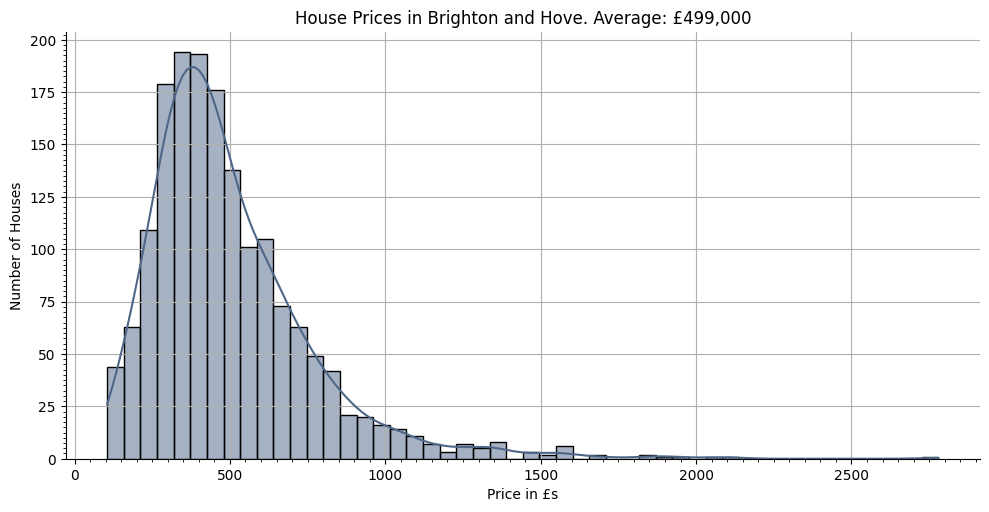

In [ ]:
sns.displot(
    merge_df.Price,
    bins=50,
    aspect=2,
    kde=True,
    color=palette["blue"],
)

plt.title(f'House Prices in Brighton and Hove. Average: £{(merge_df.Price.mean()):.3g},000')
plt.xlabel('Price in £s')
plt.ylabel('Number of Houses')
plt.grid()
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(10))
plt.show()

On visual analysis, the distribution of prices appears approximately normal, but has an overly large tail on the right side from expensive housing. A naive regression confirms an extreme kurtosis of 23.2 (3sf). Therefore, following typical housing economics standards, a log transformation is preferable.

In [ ]:
merge_df["Log Price"] = np.log(merge_df["Price"])

### 4.2.2 Covariance Visualisation

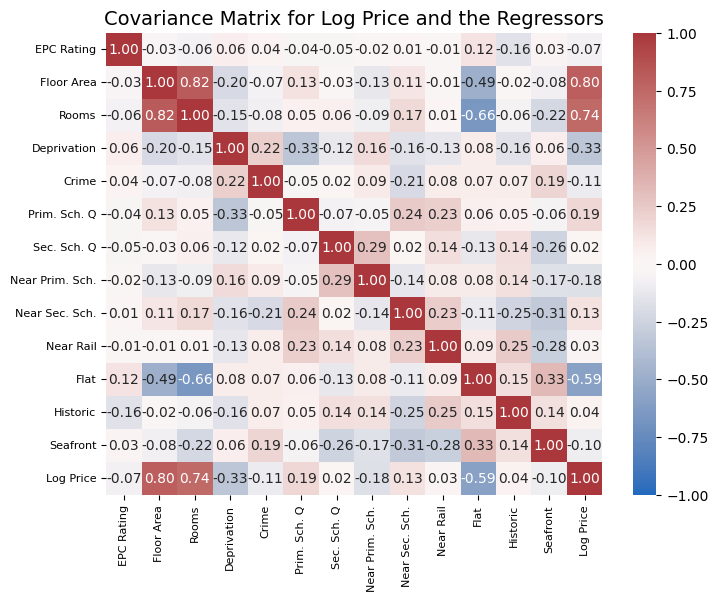

In [ ]:
data = merge_df.drop(['Price'], axis=1)
corr = data.corr()

plt.figure(figsize=(8,6))
plt.title("Covariance Matrix for Log Price and the Regressors", fontsize=14)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", vmin=-1, vmax=1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

### 4.2.3 Price vs Key Features

#### 4.2.3.1 Price vs Floor Area

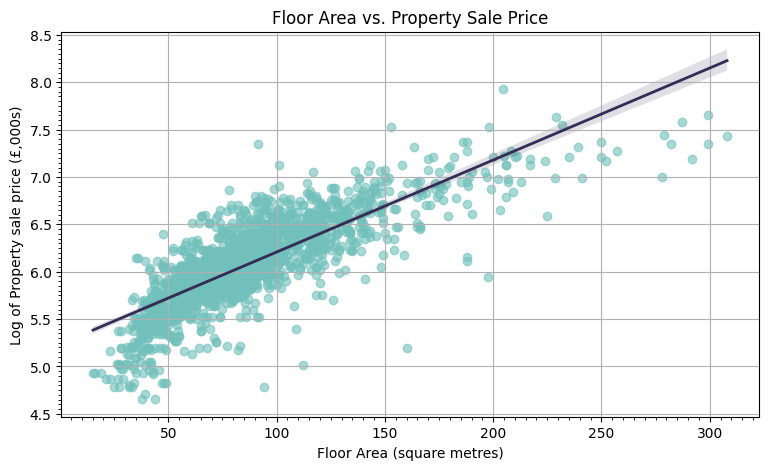

In [ ]:
plt.figure(figsize=(9,5))
plt.title("Floor Area vs. Property Sale Price")
sns.regplot(x=data["Floor Area"], y=data["Log Price"],
            scatter_kws={"color": palette["teal"], "alpha": 0.6},
            line_kws={"color": palette["navy"], "linewidth": 2})
plt.xlabel("Floor Area (square metres)")
plt.ylabel("Log of Property sale price (£,000s)")
plt.grid()
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(10))
plt.show()

#### 4.2.3.2 Price vs Deprivation

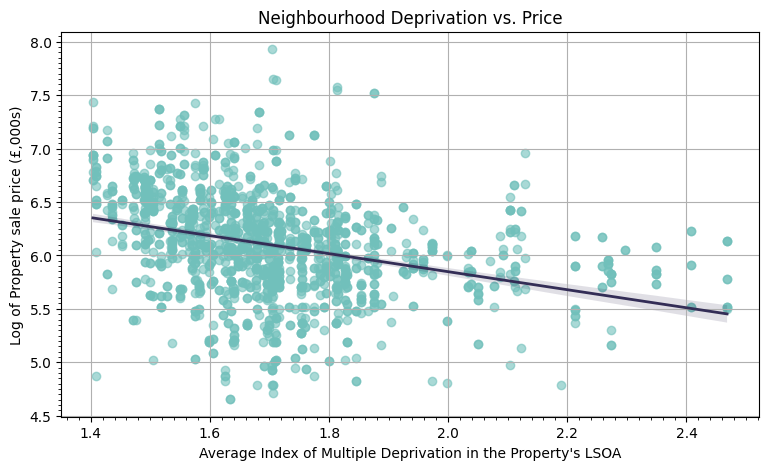

In [ ]:
plt.figure(figsize=(9,5))
plt.title("Neighbourhood Deprivation vs. Price")
sns.regplot(x=data["Deprivation"], y=data["Log Price"],
            scatter_kws={"color": palette["teal"], "alpha": 0.6},
            line_kws={"color": palette["navy"], "linewidth": 2})
plt.xlabel("Average Index of Multiple Deprivation in the Property's LSOA")
plt.ylabel("Log of Property sale price (£,000s)")
plt.grid()
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(10))
plt.show()

#### 4.2.3.3 Price vs Quality of the Nearest Primary School

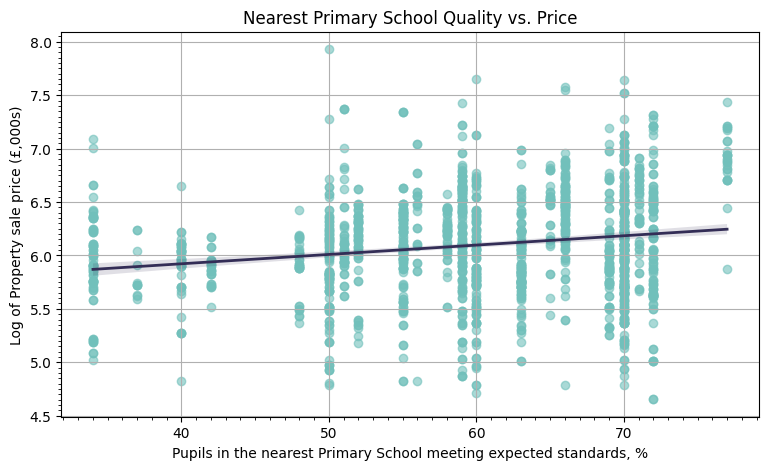

In [ ]:
plt.figure(figsize=(9,5))
plt.title("Nearest Primary School Quality vs. Price")
sns.regplot(x=data["Prim. Sch. Q"], y=data["Log Price"],
            scatter_kws={"color": palette["teal"], "alpha": 0.6},
            line_kws={"color": palette["navy"], "linewidth": 2})
plt.xlabel("Pupils in the nearest Primary School meeting expected standards, %")
plt.ylabel("Log of Property sale price (£,000s)")
plt.grid()
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(10))
plt.show()

### 4.2.4 Price vs Proximity to Amenities

In [ ]:
dummy_variables = ["Near Prim. Sch.", "Near Sec. Sch.", "Near Rail", "Flat", "Seafront", "Historic"]
df_long = data.melt(
    id_vars=["Log Price"],
    value_vars=dummy_variables,
    var_name="Feature",
    value_name="Value"
)
box_palette = {
    0: palette["teal"],
    1: palette["sage"],
}

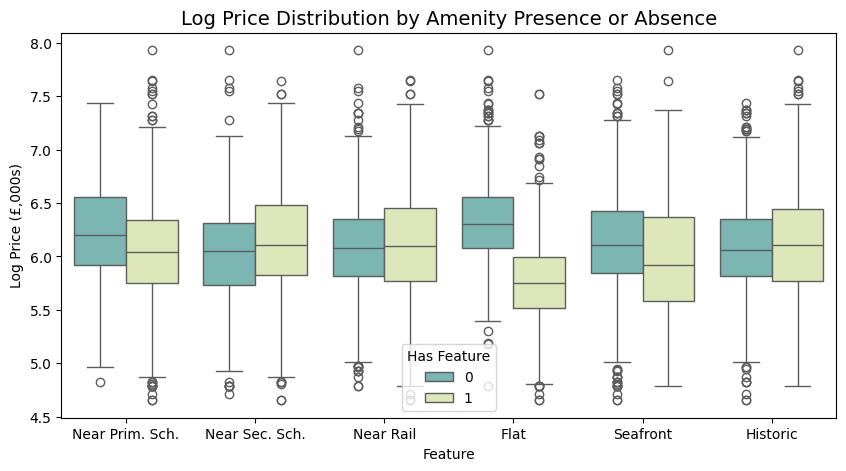

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Log Price Distribution by Amenity Presence or Absence", fontsize=14)
sns.boxplot(
    data=df_long,
    x="Feature",
    y="Log Price",
    hue="Value",
    palette=box_palette
)

plt.ylabel("Log Price (£,000s)")
plt.xlabel("Feature")
plt.legend(title="Has Feature")
plt.show()

From this, we can infer that the presence of features likely does not affect prices to any great degree. In the case of secondary schools and rail, this is to be expected due to a widespread and cheap bus network in the city, but we nevertheless see a modest increase in price from proximity.

In the case of being near primary schools, proximity may initially be expected to have a greater effect on price due to the increased supervision needs of small children. However, data also shows 99% of houses are within 1km of a primary schools, and there is a 0.2 negative covariance between being within 0.5km of a primary school and neighbourhood deprivation. This may explain the slight decrease we see.

Meanwhile, being near the seafront or in a historic property also do not seem to affect prices much. Only whether a property is a flat or a house seems to have a large effect on prices.

### 4.2.5 Distribution of Regressors and Potential Issues

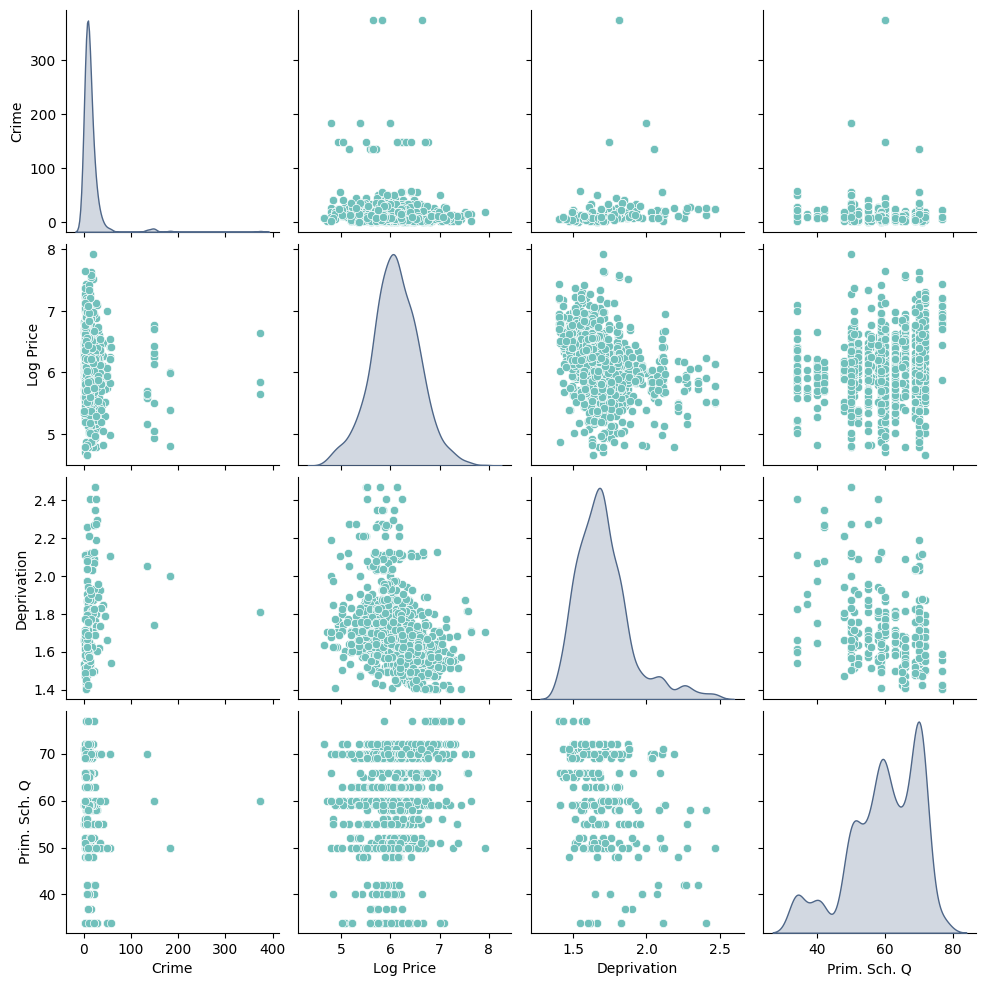

In [ ]:
predictors = ["Crime", "Log Price", "Deprivation", "Prim. Sch. Q"]
sns.pairplot(data=data[predictors], kind="scatter", diag_kind="kde",
             plot_kws={"color": palette["teal"]},
             diag_kws={"color": palette["blue"]})
plt.show()

Since crime here has extreme outliers, we will take a log of it, so that it will have a linear relationship with price.

In [ ]:
data["Log Crime"] = np.log(data["Crime"])
data.drop(["Crime"], axis=1, inplace=True)

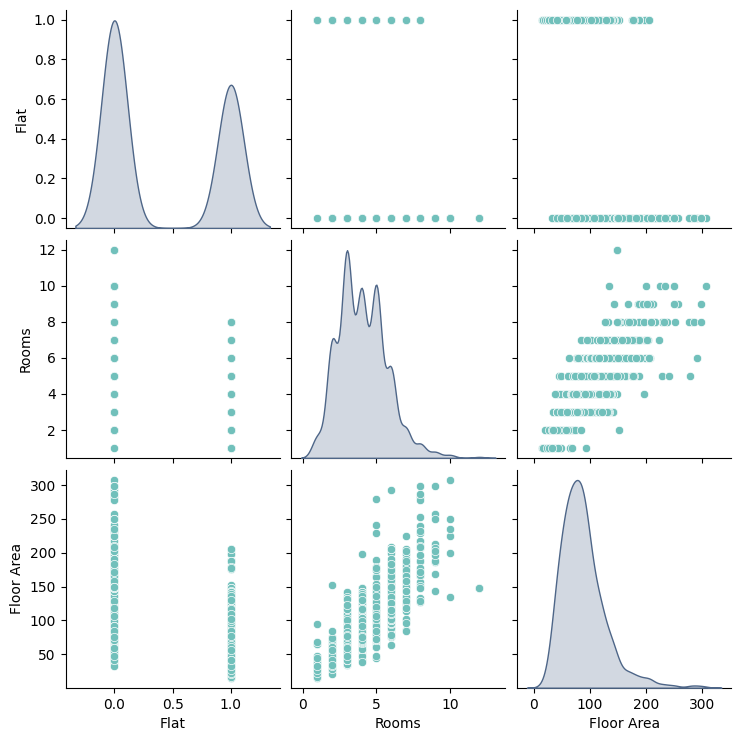

In [ ]:
predictors = ["Flat", "Rooms", "Floor Area"]
sns.pairplot(data=data[predictors], kind="scatter", diag_kind="kde",
             plot_kws={"color": palette["teal"]},
             diag_kws={"color": palette["blue"]}  )
plt.show()

Here, the strong coorelation between 'Floor Area' and 'Rooms' shown in the covariance matrix is visualised. In the next section, we will have to test this relationship for multicolinearity.

## 4.3 Diagnostics and Assumptions

In Section 5, I will be running 2 the data through both an OLS regression model and a random forest regression. Since OLS requires more assumptions, this section consists of testing whether our dataset and regressors are suitable for OLS and modifying the data towards this where necessary.

### 4.3.1 Linearity

We can confirm (see 8.) that all variables have an approximately linear relationship to the log of price

### 4.3.2 No Perfect Multicolinearity

The "Rooms" and "Floor Area" variables are theoretically and empirically (see 4.2.2 and 4.2.5) likely to be multicolinear, so we will test these here.

In [ ]:
X = data[["Floor Area", "Rooms"]]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

      feature   VIF
0  Floor Area 17.35
1       Rooms 17.35


This confirms we have extreme multicolinearity (>10) in with Rooms and data. Therefore, we will drop rooms from the linear regression:

In [ ]:
OLS_data = data.drop(columns=["Rooms"], axis=1)

As a precaution, we will also test if "Flat" and "Floor Area" are multicolinear, due to a moderately high covariance between them:

In [ ]:
X = data[["Floor Area", "Flat"]]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

      feature  VIF
0  Floor Area 1.22
1        Flat 1.22


### 4.3.3 Exogeneity

In our case, our data does not likely contain measurement error (see 3.1), and since our specification is fairly exhautive, we do not see a high likelihood of large omitted variables bias.

However, Primary and Secondary School Quality seem very likely to fall prey to reverse causality. Whilst a good school will attract more demand for houses nearby, and thus higher prices, higher prices in turn will mean only the wealthy can afford to live there. These people are likely more highly educated, and therefore more inclined and able to promote their children's education.

Furthermore, we can see below that, when we run a Jarque-Bera test, errors are not normally distributed, so any inference will likely be shaky:



In [ ]:
y = data["Log Price"]
X = data[["Prim. Sch. Q", "Sec. Sch. Q"]]
model = sm.OLS(y, X).fit()
jb_output = jarque_bera(model.resid)
print(f"P-value for normality of error term: {jb_output[1]}")

P-value for normality of error term: 1.564877779577361e-63


Therefore, it seems wise to drop Primary and Secondary School Quality from the OLS Regression.

In [ ]:
OLS_data.drop(columns=["Prim. Sch. Q", "Sec. Sch. Q"], axis=1, inplace=True)

As for the rest of the regressors, we can rule out reverse causality for any location or property type regressors, barring minor exceptions such as house to maisonette conversions.

As for crime, it is possible that lower priced neighbourhoods are more likely to be associated with crime, as poverty is a cause of crime and high housing prices are exclusionary towards the impoverished. However, this effect seems more indirect than school quality. Deprivation, by this reasoning, seems more direct, so we will drop it.

Finally, we shall drop EPC certificates, as more expensive houses are likely owned by people with more means to improve the energy efficiency of their homes.

In [ ]:
OLS_data.drop(columns=["Deprivation", "EPC Rating"], axis=1, inplace=True)

### 4.3.4 Homoskedasticity

Now, we can run an Breusch-Pagan Test to see if our homoskedasticity assumption holds for our residuals.

In [ ]:
y = OLS_data["Log Price"]
X = OLS_data.drop(["Log Price"], axis=1)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
bp_test = het_breuschpagan(model.resid, model.model.exog)
print(f"Breusch-Pagan p-value: {bp_test[1]}")

Breusch-Pagan p-value: 0.001084550198686359


We reject the null, meaning our errors are heteroskedastic. We will use cluster-robust standard errors to correct for this in both OLS regressions.

### 4.3.5 Comments

Given that we have satisfied the Gauss-Markov ssumptions for cross sectional data, we can safely say that OLS will be the best linear unbiased estimator for our linear regression if we apply the changes we have applied to our OLS_data dataframe.

# 5 - Modelling

## 5.1 Linear Regression

### 5.1.1 Baseline OLS

We will now use a baseline OLS regression that uses data indexed by the LSOA to capture unobserved custer effects.

In [ ]:
LSOA_df = LSOA_df[LSOA_df["Rooms"] < LSOA_df["Rooms"].max()]
LSOA_df["Log Price"] = np.log(LSOA_df["Price"])
LSOA_df["Log Crime"] = np.log(LSOA_df["Crime"])
LSOA_df.drop(columns=["Crime", "Price", "Rooms"], axis=1, inplace=True)

In [ ]:
y = LSOA_df["Log Price"]
X = LSOA_df.drop(["Log Price", "LSOA_CODE", "Prim. Sch. Q", "Sec. Sch. Q", "Deprivation", "EPC Rating"], axis=1)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': LSOA_df['LSOA_CODE']})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Log Price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     192.3
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           1.56e-73
Time:                        16:08:02   Log-Likelihood:                -310.27
No. Observations:                1672   AIC:                             638.5
Df Residuals:                    1663   BIC:                             687.3
Df Model:                           8                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.5632      0.059     

In [ ]:
predicted = model.fittedvalues
actual = merge_df['Log Price']
residuals = actual - predicted
rmse = np.sqrt(np.mean(residuals**2))
print("RMSE:", rmse)

RMSE: 0.25923517036230553


Now, we will test the out of sample performance to compare with the machine learning models:

In [ ]:
y = LSOA_df["Log Price"]
X = LSOA_df.drop(["Log Price", "LSOA_CODE", "Prim. Sch. Q", "Sec. Sch. Q", "Deprivation", "EPC Rating"], axis=1)
X = sm.add_constant(X)
clusters = LSOA_df['LSOA_CODE']
X_train, X_test, y_train, y_test, clusters_train, clusters_test = train_test_split(X,
                                                                                   y,
                                                                                   clusters,
                                                                                   test_size=0.2,
                                                                                   random_state=12)
model = sm.OLS(y_train, X_train).fit(cov_type='cluster', cov_kwds={'groups': clusters_train})
y_pred = model.predict(X_test)
print("When tested out of sample, our R-Squared is: ", r2_score(y_test, y_pred))

When tested out of sample, our R-Squared is:  0.7131234171764874


Whilst it is counterintuitive, the R-squared is higher out of sample than in the sample data due to randomness. Changing the train-test split by modifying the random_state sometimes produces lower, sometimes higher R-squared than the model. However, it is roughly similar. In other words, the model generalises well.

### 5.1.2 OLS With a Relaxed Exogeneity Assumptions

Now, we will relax our assumptions on exogeneity slightly, so we still exclude primary and secondary school quality, but not deprivation or EPC ratings, as they may have some slight reverse causality, but should be fine for prediction. Note: Standard errors will be cluster-robust.

In [ ]:
y = LSOA_df["Log Price"]
X = LSOA_df.drop(["Log Price", "Prim. Sch. Q", "Sec. Sch. Q", "LSOA_CODE"], axis=1)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': LSOA_df['LSOA_CODE']})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Log Price   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     180.5
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           6.35e-77
Time:                        16:08:02   Log-Likelihood:                -275.94
No. Observations:                1672   AIC:                             573.9
Df Residuals:                    1661   BIC:                             633.5
Df Model:                          10                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.1601      0.127     

In [ ]:
predicted = model.fittedvalues
actual = merge_df['Log Price']
residuals = actual - predicted
rmse = np.sqrt(np.mean(residuals**2))
print("RMSE:", rmse)

RMSE: 0.2515670290882673


Now, we will test out of sample performance with our expanded specification:

In [ ]:
y = LSOA_df["Log Price"]
X = LSOA_df.drop(["Log Price", "Prim. Sch. Q", "Sec. Sch. Q", "LSOA_CODE"], axis=1)
X = sm.add_constant(X)
clusters = LSOA_df['LSOA_CODE']
X_train, X_test, y_train, y_test, clusters_train, clusters_test = train_test_split(X,
                                                                                   y,
                                                                                   clusters,
                                                                                   test_size=0.2,
                                                                                   random_state=12)
model = sm.OLS(y_train, X_train).fit(cov_type='cluster', cov_kwds={'groups': clusters_train})
y_pred = model.predict(X_test)
print("When tested out of sample, out R-Squared is: ", r2_score(y_test, y_pred))

When tested out of sample, out R-Squared is:  0.7365023819234817


## 5.2 Machine Learning Regression

For this, we will first split the model into train and test data, then run Random Forest and XGBoost Regressions, then evaluate our models.

### 5.2.1 Random Forest

In [ ]:
y = merge_df['Price']
X = merge_df.drop(['Price', 'Log Price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=12)
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    random_state=12,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("RMSE: ", mse ** 0.5)
print("R^2 In Training Data: ", r2_score(y_train, y_train_pred))
print("R^2 When Measured Against Test Data: ", r2_score(y_test, y_pred))

RMSE:  113.06370198580042
R^2 In Training Data:  0.8708306355821794
R^2 When Measured Against Test Data:  0.7605595314491163


Here, we can see that, even with a relatively moderate sample size, the Random Forest Regression has greater explanatory power than OLS for predicting house prices, though not inferring causation.

Now, we will illustrate the most important features in predicting house price in the model:

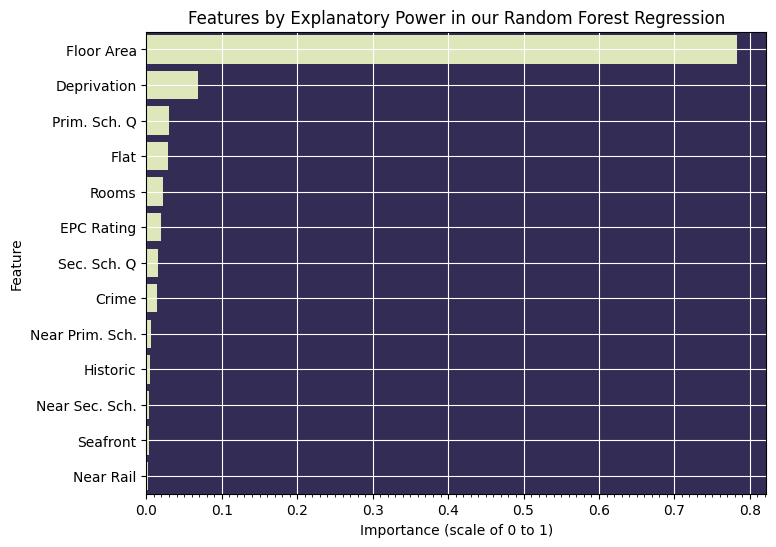

In [ ]:
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_,
})
importances = importances.sort_values("Importance", ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(
    data=importances,
    x="Importance",
    y="Feature",
    color=palette["sage"]
)
plt.title("Features by Explanatory Power in our Random Forest Regression")
plt.grid(color="white")
plt.xlabel("Importance (scale of 0 to 1)")
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
ax.set_facecolor(palette["navy"])
plt.show()

### 5.2.2 XGBoost

In [ ]:
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=12,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("RMSE: ", mse ** 0.5)
print("R^2 In Training Data: ", r2_score(y_train, y_train_pred))
print("R^2 When Measured Against Test Data: ", r2_score(y_test, y_pred))

RMSE:  106.08176249658501
R^2 In Training Data:  0.8708306355821794
R^2 When Measured Against Test Data:  0.7892184447439269


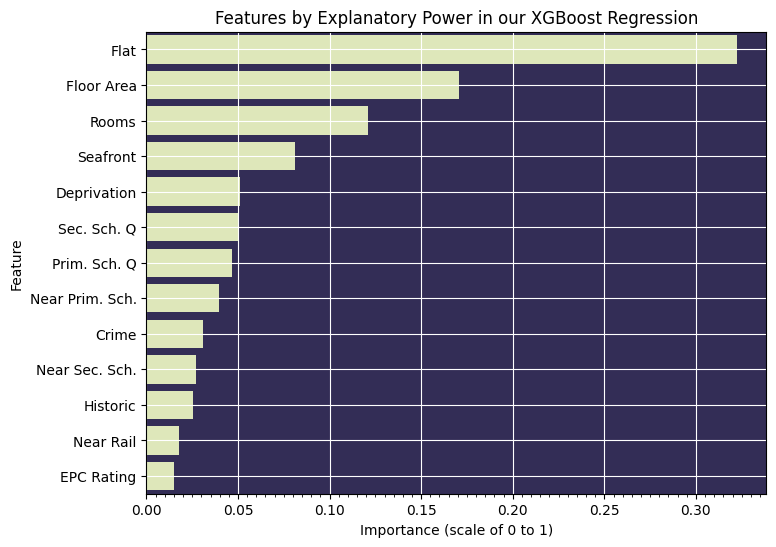

In [ ]:
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb.feature_importances_,
})
importances = importances.sort_values("Importance", ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(
    data=importances,
    x="Importance",
    y="Feature",
    color=palette["sage"]
)
plt.title("Features by Explanatory Power in our XGBoost Regression")
plt.grid(color="white")
plt.xlabel("Importance (scale of 0 to 1)")
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
ax.set_facecolor(palette["navy"])
plt.show()

# 6 - Discussion and Insights

## 6.1 Recap of Objectives

The aim of this project was to explore the determinants of house prices in Brighton and Hove and to assess how accurately these can be predicted by linear regressions and machine learning approaches based on publically available data. In particular, the aim was to:

*   Compare the predictive power on house prices of more flexible machine learning models against traditional linear regressions
*   Identify which features are most strongly associated with higher/lower house prices
*   Evaluate whether machine learning models yield greater predictive accuracy compared to linear regressions.

To meet these aims, we constructed two OLS specifications with different sets of regressors, alonside a Random Foret regression and an XGBoost regression for machine learning.

## 6.2 Comparative Model Performance

Overall, machine learning models (R^2 = 0.761 and R^2=0.789) performed slightly better than the OLS models (R^2 = 0.713 and R^2=0.737), measured on performance in out of sample data. This is likely due to OLS having more strict assumptions, and therefore not as able to make as much use of the features. Additionally, due to the many unobserved characteristics of house price (negotiation skills of the seller, cleanliness of the house, garden size, etc), there is a limit on how large R^2 can be.

Also important to note is the difference in R^2 between the machine learning models themselves. Because the dataset is large, clean, and the relationships between features are complex, it's expected that, due to correcting for past errors, XGBoost will outperform Random Forest, which turns out to be the case.

As for accuracy of the fit, the expanded OLS model has a slightly lower (2.52 vs. 2.59) RMSE than the restricted specification model, and with the machine learning models, XGBoost had a slightly lower RMSE than Random Forest (107 vs. 118). However, it is misleading to compare between the OLS and machine learning regressions, as the residuals are in logs in OLS and in raw numbers in the machine learning models.


## 6.3 Interpretation of Model Results

Firstly, whilst our machine learning models make more accurate predictions of prices given our features, they are 'black boxes' so to speak, so whilst they will be used to make actual predictions, interpreting the predictions is best done by OLS.

Assuming that we can use 'Flat' as a proxy for not having a garden, whereas most houses will, the primary conclusion of both machine learning and OLS models is that the main determinant of house prices is land: both built (floor area and number of rooms) and non built (garden). This is to be expected. However, there are some more interesting insights beneath this.

Firstly, deprivation has a more major impact on house price than crime. This may chime with the idea that, since Brighton is relatively safe even in higher-crime areas, it doesn't come into the calculation for property buyers, whereas deprived areas drive down price because of unobserved characteristics, like neighbourhood cleanliness, and wealthier people wanting to have neighbours in a similar social class to themselves. Whilst there is undoubtedly some reverse causality, it is nevertheless an important feature in predicting price in the XGBoost model, accounting for about 5% of price variation.

Secondly, whilst location-based amenities do not seem to have much impact on price from the visualisation (see 4.2.4), these effects appear once other effects are controlled for in OLS. Interestingly, whilst the median seafront property is worth less than the median inland property, the OLS coefficient for the seafront regressor is positive. On further thought, this is intuitive: whilst the seafront area disproportionately captures deprived areas, notably Portslade, there is, nevertheless, a premium on living near the sea given the area.

The other coefficients do not throw up surprises, with period buildings being significantly more expensive, and the impact of nearby rail and secondary schools being positive but of dubious significance. The exception is primary schools being nearby having a strong negative coefficient. Perhaps this is due to noise concerns, and closeness to a primary school not being a concern, as 99% of properties are within 1km of a primary school.

Finally, EPC rating appears to have no impact at all on buyer's property choices, and whilst primary and secondary school quality are important for prediction (see the XGBoost model), they provide almost a textbook case of reverse causality, so they had to be excluded from the OLS specification, even in the expanded model.

## 6.4 Rationale for Data Preprocessing Choices

Several data preprecessing choices were made to ensure model performance.

**Transformations:** House prices were log-transformed, following standard practice in predictive modelling of property prices, to reduce kurtosis (see 4.2.1), and linearise relationships between features and the outcome (see 8). Crime was also log-transformed due to a small number of LSOAs with very high crime counts, which would otherwise skew the model.

**Distance Variables:** The primary school distance threshold was set at 0.5km to reflect the parental desire to walk younger children to school before work rather than drive. A 2km threshold was applied to secondary schools, where students are generally more independent but longer distances may require paid transport. The railway stations threshold was set at 1km to reflect a short walk to the station, not only to commute to London but also to regional destinations (e.g. University of Sussex). A 0.5km threshold was added to the seafront variable to reflect being a very short distance from the beach. Some features were insignificant in the model, but were included for conceptual completeness.

**Multicolinearity:** The number of rooms was dropped as an OLS regressor due to multicolinearity with floor area. Floor area was retained as it is continuous and provides a clearer picture of property size.

**Cleaning and Sample Selection:** Observations with NaN values and duplicates were dropped, as there were very few. The dataset was restricted to 2025 sale prices. This both simplified the analysis and avoided the need for panel methods, while ensuring results are broadly applicable to the current housing market.

## 6.5 Data Sources, Limitations and Visualisations

**Data Sources:** Most datasets here are sourced from UK Government open data providers. These include EPC certificates data from the Department for Levelling Up, Housing and Communities, deprivation data from the 2021 UK Census from the Office of National Statistics, 2025 house sale price data from HM Land Registry, 2024 school comparison data from the Department for Education, and 2025 police open data from the Home Office. To construct school and railway station location variables, I used Google Maps. The seafront variable required calculating distance from a line rather than a point, and therefore required mean coastline geometry from OpenStreetMap.

**Limitations:** Due to reliance on open source datasets, important features such as garden size could not be obtained for our regression. Nevertheless, we had enough data to contruct a model with a good degree of predictive power.

**Visualisation:** Visualisations were used both as a tool for exploring data and presenting results. The price distribution hinted that price should be logged, and the covariance matrix showed both the most likely determinants of price and the variables we should perform multicolinearity tests on. Our location-based boxplot indicates that seafront is the only location-based amenity that shifts price to a large degree.

## 6.6 Insights and Practical Applications

**Sellers:** Anyone selling a property, whether individual or commercial (such as estate agents) can use the machine learning model to estimate the underlying value of the house. More importantly, it can be used by individuals and developers to forecast how much value will be added to the property by potential renovation, given current property characteristics and differences to rooms and floor size. This can then be compared to labour and materials cost to determine if rennovation will be sufficiently profitable to be worth carrying out.

**Buyers:** Similarly, buyers can determine the underlying value of a house for negotiation purposes. Furthermore, they can use the OLS model to estimate how much of a premium features will carry for the property they want (since features don't add value linearly). They can then evaluate whether they are willing to pay for those features or not, and if not, they can filter those out of their property search, saving time and effort.

**Policy Implications:** Local councils may not that deprivation has a much larger impact on property prices than crime. Since this is a priority for both council tax revenue and reelection prospects, councilors may want to implement polcies to reduce the visual deprivation that likely reduces house prices, such as uncleanliness and poor road maintenence. Furthermore, EPC Ratings seem to have no significance at all on house prices, indicating that energy efficiency is not yet priced into the market. Therefore, the government should implement greater incentives if they want a greener housing stock.

**Methodological Insights:** Machine Learning outperforms traditional OLS methods for house price prediction, but lacks easy interpretability. Therefore, for the purposes we have enumerated above, we should combine both. Additionally, the relatively modest R squared of just below 0.8 out of sample suggests that we can only truly use the model as a rough yardstick. It illustrates the importance of either unobserved data that is not readily available, such as garden size, and data that *can't* be observed, such as the negotiating position and ability of the buyer and seller.

**Future Directions:** If richer data were available, the predictive power of the model would increase. If increased enough, this could then feasibly be used commercially, or for a service marketed to invidiuals. It could also potentially be quickly modified for other cities in the UK, with the exception of the seafront variable, which distinguishes Brighton as a property market. Another extension could be adding other years with panel data and time effects. This could then be used for price forecasting.

# 7 - Conclusions

This project explored the determinants of house prices in Brighton and Hove and compared traditional regression with machine learning models to assess performance. Random Forest and XGBoost outperformed OLS regressions, with an out-of-sample R^2 of ~0.79-0.76 compared to ~0.74-0.71. This demonstrates the value of flexible, non-linear models when dealing with housing data.

By far the largest determinants of house price involved land, both built (rooms, floor area) and non-built (flat, a proxy for garden area). However, houses being period properties, close to the sea, and in less deprived areas proved to be highly important, whereas being close to schools and being energy efficient were not.

This modelling approach can be used for a multitude of purposes, from estimating the revenue from rennovations, to benchmarking valuations when negotiating property transactions, to filtering worthwhile property searches, as well as informing policy decisions.

The analysis was limited to one year of transactions, as well as only mapping and government data. Future improvements could therefore extend the model through panel data implementation and richer feature engineering.

# 8 - Appendix

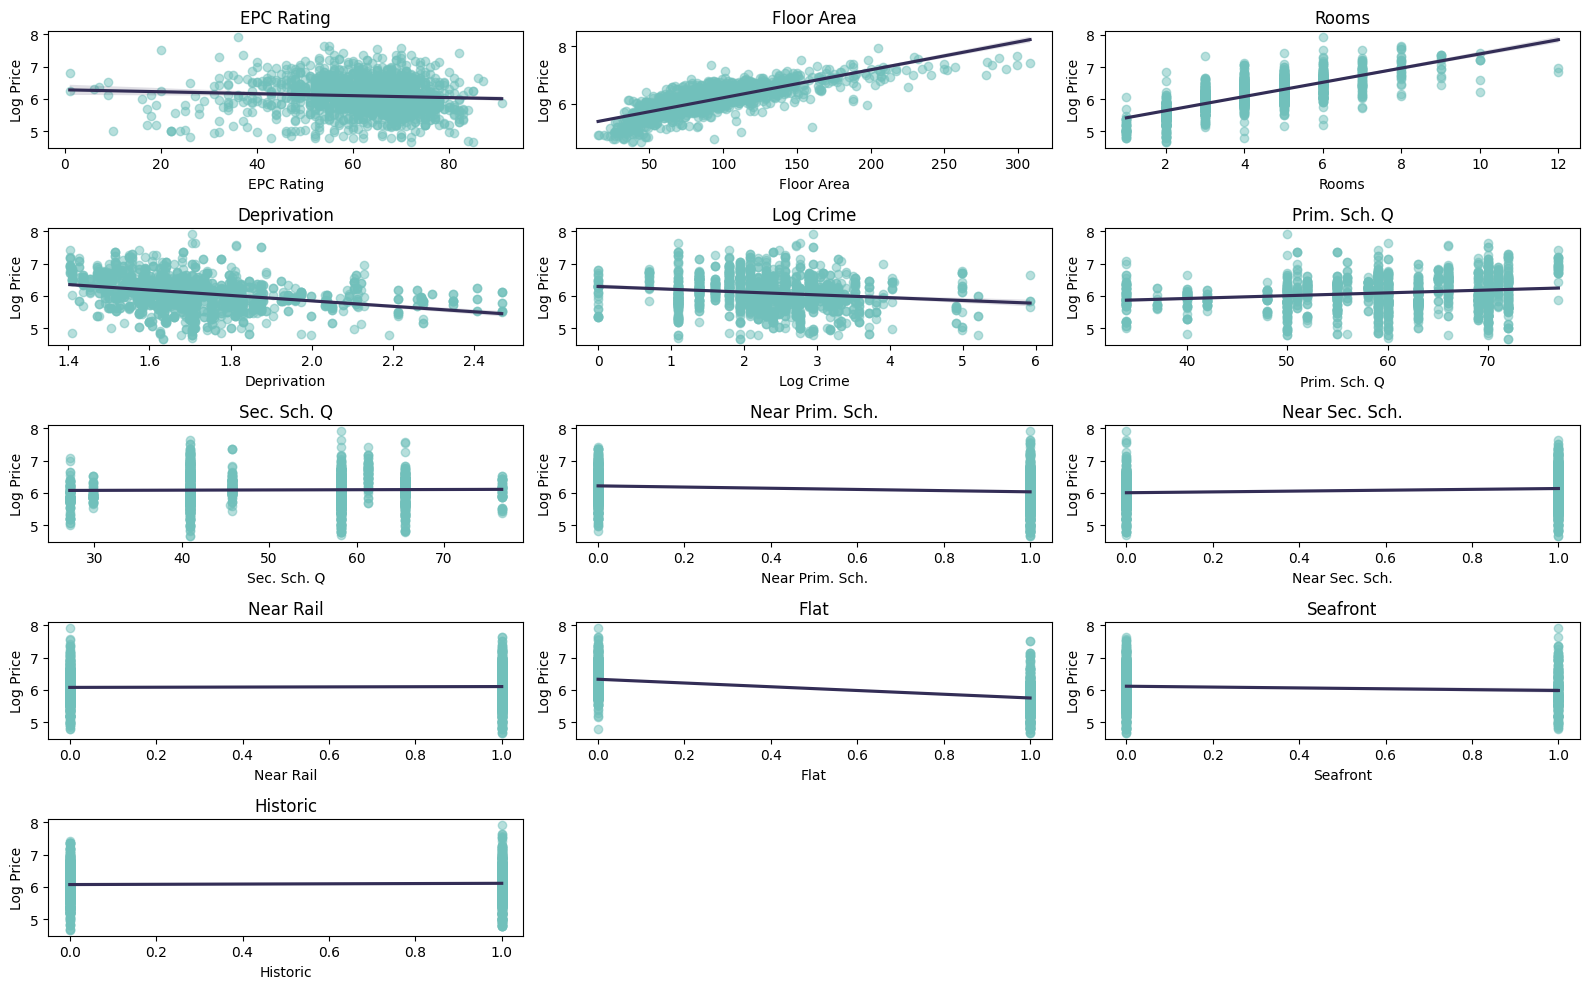

In [ ]:
predictors = ["EPC Rating", "Floor Area", "Rooms",
              "Deprivation", "Log Crime", "Prim. Sch. Q",
              "Sec. Sch. Q", "Near Prim. Sch.",
              "Near Sec. Sch.", "Near Rail", "Flat",
              "Seafront", "Historic"]

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16, 10))
axes = axes.flatten()

for i, var in enumerate(predictors):
    sns.regplot(
        x=data[var],
        y=data["Log Price"],
        ax=axes[i],
        scatter_kws={"color": palette["teal"], "alpha":0.5},
        line_kws={"color": palette["navy"]}
    )
    axes[i].set_title(var)

# Remove any unused subplots
for j in range(len(predictors), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()